# FZD5

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.5.1.dev0


### FZD5
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FZD5.

In [3]:
gene_symbol = 'FZD5'
mane_tx_id = 'NM_003468.4'
mane_protein_id = 'NP_065979.1' # zinc finger SWIM domain-containing protein 6"

In [5]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed:  39%|███▉      | 11/28 [01:18<02:46,  9.79s/individuals]

Expected a result but got an Error for variant: 2_207767590_207767590_C_G
<html><body><h1>503 Service Unavailable</h1>
No server is available to handle this request.
</body></html>



Individuals Processed:  46%|████▋     | 13/28 [01:57<03:32, 14.15s/individuals]

Expected a result but got an Error for variant: 2_207768352_207768352_G_T
<html><body><h1>503 Service Unavailable</h1>
No server is available to handle this request.
</body></html>



Individuals Processed: 100%|██████████| 28/28 [03:38<00:00,  7.81s/individuals]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #11
    variants
     errors:

      #0
       warnings:
       ·Patient PMID_36695497_Individual_5 has an error with variant 2_207767590_207767590_C_G. Try again or remove variant form testing... Expected a result but got an Error. See log for details.
  patient #15
    variants
     errors:

      #0
       warnings:
       ·Patient PMID_33633439_17413_II_1 has an error with variant 2_207768352_207768352_G_T. Try again or remove variant form testing... Expected a result but got an Error. See log for details.


In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Iris coloboma,HP:0000612,16
Nystagmus,HP:0000639,9
Chorioretinal coloboma,HP:0000567,8
Retinal coloboma,HP:0000480,8
Optic disc hypoplasia,HP:0007766,7
Reduced visual acuity,HP:0007663,6
High myopia,HP:0011003,5
Optic disc coloboma,HP:0000588,4
High hypermetropia,HP:0008499,3
Microphthalmia,HP:0000568,2


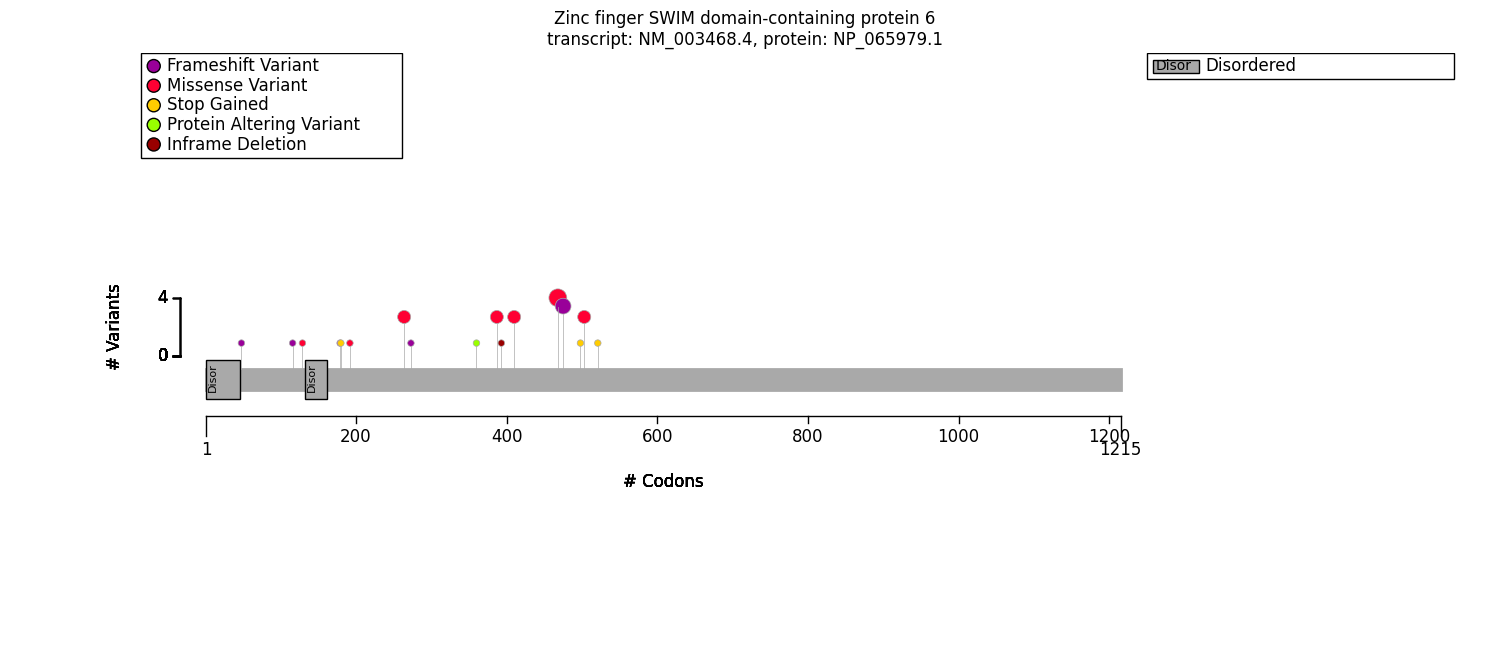

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
    term_frequency_threshold=0.1,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = monoallelic_predicate(a_predicate=missense, b_predicate=~missense, names=("missense", "other"))
gt_predicate.display_question()

'Allele group: missense, other'

In [11]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF02,Skipping term because no genotype has more than one observed HPO count,3
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,12
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,6


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Iris coloboma [HP:0000612]                             2/11     18%  12/15   
Retinal coloboma [HP:0000480]                           1/7     14%    6/9   
Optic disc hypoplasia [HP:0007766]                      5/7     71%    2/6   
Optic disc coloboma [HP:0000588]                        0/2      0%    4/8   
Strabismus [HP:0000486]                                0/11      0%   2/12   
Nystagmus [HP:0000639]                                 2/11     18%   5/15   
Microphthalmia [HP:0000568]                             0/2      0%    2/8   
Aplasia/Hypoplasia affecting the eye [HP:0008056]       6/6    100%    4/4   
Coloboma [HP:0000589]                                   3/3    100%  13/13   
Abnormality iris morphology [HP:0000525]                2/2    100%  12/12   
Chorioretinal coloboma [HP:0000567]                     1/2     50%    6/8   
Abnormal chorioretinal morphology [HP:0000532]          1/1    100%    6/6   
Abnormal fundus morphology [HP:0001098]                 8/8    100%  14/14   
Abnormal retinal morphology [HP:0000479]                3/3    100%  11/11   
High hypermetropia [HP:0008499]                         2/6     33%    1/4   
Aplasia/Hypoplasia of the optic nerve [HP:0008058]      5/5    100%    2/2   
Aplasia/Hypoplasia affecting the fundus [HP:000...      6/6    100%    2/2   
Abnormal optic nerve morphology [HP:0000587]            5/5    100%    6/6   
Reduced visual acuity [HP:0007663]                      4/8     50%    2/4   
Abnormal involuntary eye movements [HP:0012547]         2/2    100%    5/5   
High myopia [HP:0011003]                                2/6     33%    3/8   

Allele group                                                                   \
                                                   Percent Corrected p values   
Iris coloboma [HP:0000612]                             80%           0.090598   
Retinal coloboma [HP:0000480]                          67%           0.631469   
Optic disc hypoplasia [HP:0007766]                     33%           1.000000   
Optic disc coloboma [HP:0000588]                       50%           1.000000   
Strabismus [HP:0000486]                                17%           1.000000   
Nystagmus [HP:0000639]                                 33%           1.000000   
Microphthalmia [HP:0000568]                            25%           1.000000   
Aplasia/Hypoplasia affecting the eye [HP:0008056]     100%           1.000000   
Coloboma [HP:0000589]                                 100%           1.000000   
Abnormality iris morphology [HP:0000525]              100%           1.000000   
Chorioretinal coloboma [HP:0000567]                    75%           1.000000   
Abnormal chorioretinal morphology [HP:0000532]        100%           1.000000   
Abnormal fundus morphology [HP:0001098]               100%           1.000000   
Abnormal retinal morphology [HP:0000479]              100%           1.000000   
High hypermetropia [HP:0008499]                        25%           1.000000   
Aplasia/Hypoplasia of the optic nerve [HP:0008058]    100%           1.000000   
Aplasia/Hypoplasia affecting the fundus [HP:000...    100%           1.000000   
Abnormal optic nerve morphology [HP:0000587]          100%           1.000000   
Reduced visual acuity [HP:0007663]                     50%           1.000000   
Abnormal involuntary eye movements [HP:0012547]       100%           1.000000   
High myopia [HP:0011003]                               38%           1.000000   

Allele group                                                  
                                                    p values  
Iris coloboma [HP:0000612]                          0.004314  
Retinal coloboma [HP:0000480]                       0.060140  
Optic disc hypoplasia [HP:0007766]                  0.286131  
Optic disc coloboma [HP:00